# **Task 1- Exploratory Data Analysis (EDA)**

### **1. Import Necessary Libraries Required for EDA**
***

In [1]:
# Run "pip install -r requirements.txt" prior to running the eda.ipynb 
# Otherwise, unhash ?and run the following installations below
# pip install summarytools
# pip install python-dotenv

import os
from dotenv import load_dotenv
import urllib.request 
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from summarytools import dfSummary
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **2. Download .db file from URL and Save the Dataset into DataFrame**
***

In [2]:
# Get the database URL from environment variables in .env file
# If .env is not step up but survive.db is downloaded, proceed to step: 
# 'Establishing connection and saving dataset into survive_df'
load_dotenv()
weather_url = os.environ.get("weather_url")
air_quality_url = os.environ.get("air_quality_url")

In [3]:
# Downloading dataset into from given URL and saving into dataset folder
urllib.request.urlretrieve(weather_url, "data/weather.db")
urllib.request.urlretrieve(air_quality_url, "data/air_quality.db")

('data/air_quality.db', <http.client.HTTPMessage at 0x25bf24d5c10>)

In [4]:
# Establishing connection and saving dataset into survive_df
weather_connection = sqlite3.connect("data/weather.db")
weather_df = pd.read_sql_query("SELECT * from weather", weather_connection)
air_quality_connection = sqlite3.connect("data/air_quality.db")
air_quality_df = pd.read_sql_query("SELECT * from air_quality", air_quality_connection)

weather_connection.commit()
air_quality_connection.commit()
weather_connection.close()
air_quality_connection.close()

### **3A. Overview of the weather_df Dataset**
***
This information can be used for the data preprocessing step and to check for duplicates, the shape, data type, counts, number of missing values, min, max, mean values.

In [5]:
dfSummary(weather_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,data_ref[object],1. 0895190a-78ae-4138-8d28-b09b152. 6ef41128-cb98-462c-b165-10fe703. 0acf11b1-b4c3-4297-96c2-63af994. 8d9fd485-0436-4c24-8416-447d9f5. cefa5266-ae45-487c-ada3-d72d9e6. 8d6affd7-74b0-4af9-aa7f-f0d1717. c54e8e47-05d0-49d6-9a3b-959a288. aab49f55-a6b2-4595-9629-1400779. 6d40d08d-861d-40f2-b273-f4037a10. d3864f15-a274-4dfe-95cd-672fa011. other,"3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3,487 (99.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,date[object],1. 17/12/20142. 24/11/20163. 27/04/20154. 09/10/20225. 15/05/20186. 13/12/20177. 09/06/20178. 19/03/20159. 14/10/202210. 26/05/201611. other,"3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3,487 (99.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
3,Daily Rainfall Total (mm)[object],1. 02. -3. --4. 0.25. 0.46. 0.67. 0.88. 1.69. 110. 1.411. other,"1,661 (47.2%)174 (4.9%)167 (4.7%)135 (3.8%)70 (2.0%)65 (1.8%)61 (1.7%)43 (1.2%)38 (1.1%)37 (1.1%)1,066 (30.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAEYElEQVR4nO3dQW4TWQBF0Z/IosnEloWUZbAAL6IX24vwAthHFKUGOM0kPYCO6BZxApRvxXDOjNkXulRUpf/IxcPDw4DC5dIH

From the summary of the weather_df, we can observe:
1. Duplications overall dataset and in the `data_ref` and `date` columns.
2. Data types of multiple columns are not configured appropriately.
3. Multiple columns contains '-' and '--' in the dataset, which can be represented as NaN.
4. Missing values in multiple columns, including for the values '-' and '--' listed above.
5. Negative values for `Wet Bulb Temperature (deg F)`
6. Multiple categorical values representing same things for column `Dew Point Category` and `Wind Direction`

All these discrepancies will be explored and rectified in next.

### **3B. Data Cleaning and Pre-Processing for weather_df**
***
To prepare the data for model fitting, by:
- Checking for duplicated values and `data_ref` column
- Converting Datatypes,
- Assumptions made to drop columns,
- Mapping labels to make all values more consistent,
- Converting negative values,
- Filling missing values,
- Additional Feature Engineering

#### Check if Duplicated `data_ref` in Dataset are Consistent
Check through all the columns in dataframe to confirm that the rows are duplicated across all columns.

In [6]:
weather_df['data_ref'].duplicated().value_counts()

False    3197
True      320
Name: data_ref, dtype: int64

In [7]:
weather_df.duplicated().value_counts()

False    3197
True      320
dtype: int64

Since it is shown that the duplicated values in weather_df['data_ref'] is due to the replication in the whole row of data, we will proceed to drop all the *320* duplicates.

In [8]:
weather_df.drop_duplicates(inplace = True)

#### Check if there are any remaining `date` duplicate values

In [9]:
weather_df['date'].duplicated().value_counts()

False    3197
Name: date, dtype: int64

All the duplicated values in `date` are removed in the prior step. Now let's convert data type of `date` to *datetime*.

In [10]:
weather_df['date'] = pd.to_datetime(weather_df['date'], dayfirst = True)

In [11]:
weather_df['day'] = pd.to_datetime(weather_df['date'], dayfirst = True).dt.day
weather_df['month'] = pd.to_datetime(weather_df['date'], dayfirst = True).dt.month
weather_df['year'] = pd.to_datetime(weather_df['date'], dayfirst = True).dt.year

#### Continuous variables: RainFall, Temperature, Wind Speed

It is noted that the across the columns of rainfall and temperature records, there are multiple '-' and '--' values which represents null values. We will proceed to change them to NaN values first.

In [12]:
weather_df = weather_df.replace('-', np.nan)
weather_df = weather_df.replace('--', np.nan)

The datatype of these columns are also converted to float for the subsequent steps.

In [13]:
weather_df = weather_df.astype({col: float for col in weather_df.columns[2:11]})

With that set up, let us dive into the columns.

#### RainFall

Text(0.5, 1.0, 'Daily Rainfall Over Time')

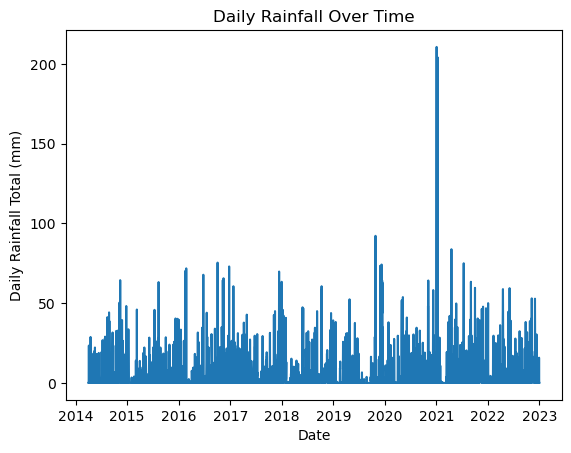

In [14]:
sns.lineplot(x='date', y='Daily Rainfall Total (mm)', data=weather_df)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Daily Rainfall Total (mm)')
plt.title('Daily Rainfall Over Time')

In [15]:
weather_df[weather_df['Daily Rainfall Total (mm)']>200]

,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),...,Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,day,month,year
2468,56ee045d-8ec0-4baa-8419-77f8afa0a5df,2021-01-02,210.6,23.6,40.2,61.6,23.1,24.1,7.9,37.0,...,100.0,55.8,100.0,1011,High,NE,Low,2,1,2021
2476,06a0ca15-4fe8-40a3-abee-8923408fc4fe,2021-01-10,204.0,22.0,36.8,54.6,23.9,24.6,8.5,33.3,...,100.0,57.2,100.0,1017,HIGH,SOUTHEAST,High,10,1,2021


This data corresponds with the NEA website, indicating that "The highest daily total rainfall of 210.6 mm was recorded at the Changi climate station on 2 January 2021" and it was the wettest day in Singapore

Missing values in 'Daily Rainfall Total (mm)' is filled with the maximum value of the next 3 columns on rainfall, if all are missing, it will be filled with 0.

In [16]:
weather_df['Daily Rainfall Total (mm)'] = weather_df['Daily Rainfall Total (mm)'].fillna(
    weather_df[['Highest 120 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 30 Min Rainfall (mm)']].max(axis=1)).fillna(0)

In [17]:
weather_df['Highest 30 Min Rainfall (mm)'] = weather_df['Highest 30 Min Rainfall (mm)'].fillna(
    weather_df['Highest 60 Min Rainfall (mm)']).fillna(
        weather_df['Highest 120 Min Rainfall (mm)']).fillna(
            weather_df['Daily Rainfall Total (mm)'])

In [18]:
weather_df['Highest 60 Min Rainfall (mm)'] = weather_df['Highest 60 Min Rainfall (mm)'].fillna(
    weather_df['Highest 120 Min Rainfall (mm)']).fillna(
        weather_df['Daily Rainfall Total (mm)'])

In [19]:
weather_df['Highest 120 Min Rainfall (mm)'] = weather_df['Highest 120 Min Rainfall (mm)'].fillna(
    weather_df['Daily Rainfall Total (mm)'])

#### Temperature

Text(0.5, 1.0, 'Daily Temperature Over Time')

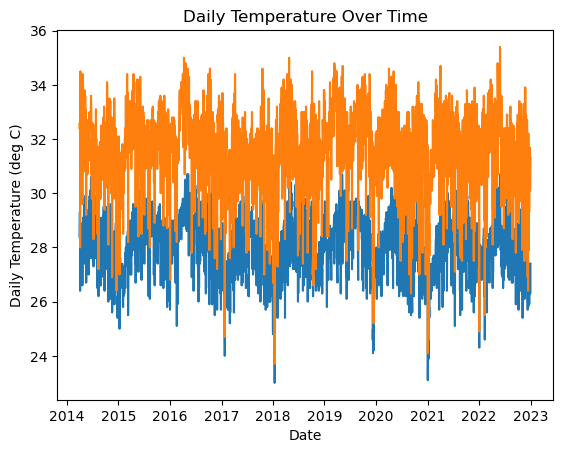

In [20]:
sns.lineplot(x='date', y='Min Temperature (deg C)', data=weather_df)
sns.lineplot(x='date', y='Maximum Temperature (deg C)', data=weather_df)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Daily Temperature (deg C)')
plt.title('Daily Temperature Over Time')

Temperature, seem to be on a wavelike trend across the year , hence we would use the forward fill method to fill the missing values

In [21]:
weather_df['Min Temperature (deg C)'] = weather_df['Min Temperature (deg C)'].ffill()
weather_df['Maximum Temperature (deg C)'] = weather_df['Maximum Temperature (deg C)'].ffill()

Text(0.5, 1.0, 'Daily Wind Speed Over Time')

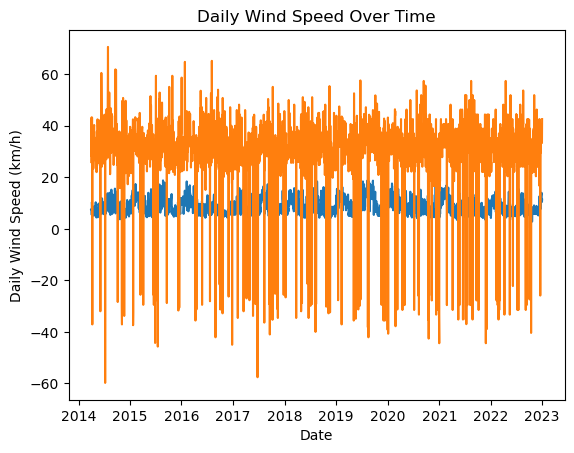

In [22]:
sns.lineplot(x='date', y='Min Wind Speed (km/h)', data=weather_df)
sns.lineplot(x='date', y='Max Wind Speed (km/h)', data=weather_df)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Daily Wind Speed (km/h)')
plt.title('Daily Wind Speed Over Time')

Max wind speed appears to be negative on some days, which I'd assume that the wind is blowing in another direction. However, for the purpose of this analysis, we would take the wind speed regardless of the direction of the wind.

In [23]:
weather_df['Max Wind Speed (km/h)'] = weather_df['Max Wind Speed (km/h)'].abs()

Filled missing values via forward fill. IF missing values are in 2 rows consecutively, the mean of the column is imputed.

In [24]:
weather_df['Min Wind Speed (km/h)'] = weather_df['Min Wind Speed (km/h)'].ffill()
weather_df['Max Wind Speed (km/h)'] = weather_df['Max Wind Speed (km/h)'].ffill()
weather_df['Max Wind Speed (km/h)'].fillna(weather_df['Max Wind Speed (km/h)'].mean)

0       25.9
1       33.1
2       43.2
3       33.1
4       28.1
        ... 
3192    37.0
3193    33.3
3194    33.3
3195    33.3
3196    42.6
Name: Max Wind Speed (km/h), Length: 3197, dtype: float64

#### Sunshine Duration (hrs), Cloud Cover (%)

In [25]:
weather_df[weather_df['Sunshine Duration (hrs)'].isna()]

,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),...,Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,day,month,year
315,9b1ae58e-5f93-42b7-87be-f795e7d4d2ef,2015-02-10,0.0,0.0,0.0,0.0,26.7,30.7,17.4,39.2,...,NaN,56.7,90.5,1017,High,W,Low,10,2,2015
316,c7e8ce6c-2910-435a-9f32-2a2b45db2fd6,2015-02-11,0.0,0.0,0.0,0.0,26.6,31.1,17.4,39.2,...,NaN,56.1,100.0,1013,HIGH,W,Medium,11,2,2015
317,94df516d-3eaf-46d0-864c-e63798e99e4a,2015-02-12,0.0,0.0,0.0,0.0,26.3,30.8,17.4,39.2,...,NaN,56.4,89.0,1009,High,NW,Low,12,2,2015
318,2983cc7a-2e35-4295-80bf-897f7efe84a5,2015-02-13,0.0,0.0,0.0,0.0,26.6,30.8,10.4,39.2,...,NaN,56.8,95.7,1012,High,S,Medium,13,2,2015
904,8dd8cfaa-d51b-450a-8a61-f757b62e7164,2016-09-21,2.5,2.5,2.5,2.5,28.1,33.6,9.0,39.6,...,NaN,58.0,100.0,1008,Below Average,SE,Medium,21,9,2016
2192,12d4eea1-7a73-4122-bbf5-f2a966b2dd12,2020-04-01,0.0,0.0,0.0,0.0,29.3,32.7,11.2,32.8,...,NaN,59.5,100.0,1013,High,W,Medium,1,4,2020
2204,12dcae2f-cad4-4c52-86c0-3267d8f13f92,2020-04-13,0.0,0.0,0.0,0.0,28.7,33.7,8.4,31.5,...,NaN,59.9,77.7,1007,high,SE,Medium,13,4,2020
2312,c335a977-b85c-4338-b20a-9c6a66ecfa84,2020-07-30,0.6,0.4,0.4,0.6,28.2,31.6,7.9,31.5,...,NaN,59.1,100.0,1011,Very High,N,Medium,30,7,2020
2342,4856d32f-3f24-4b3b-b67a-fd46f2479348,2020-08-29,6.6,2.8,4.8,4.8,27.2,30.8,8.0,33.3,...,NaN,58.6,100.0,1011,High,SE,Low,29,8,2020
2437,fc445eda-7f3b-41ac-b982-d7b03c35a776,2020-12-02,4.6,4.4,4.6,4.6,27.6,31.6,4.8,20.4,...,NaN,59.4,95.8,1006,high,SW,Medium,2,12,2020


we can fill all the missing values with the mean of the column values.

In [26]:
weather_df['Sunshine Duration (hrs)'] = weather_df['Sunshine Duration (hrs)'].fillna(weather_df['Sunshine Duration (hrs)'].mean())
weather_df['Cloud Cover (%)'] = weather_df['Cloud Cover (%)'].fillna(weather_df['Cloud Cover (%)'].mean())

Text(0.5, 1.0, 'Daily Wet Bulb Temperature Over Time')

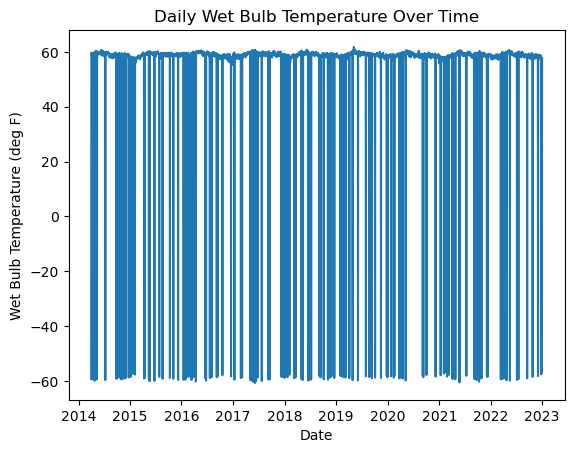

In [27]:
sns.lineplot(x='date', y='Wet Bulb Temperature (deg F)', data=weather_df)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Wet Bulb Temperature (deg F)')
plt.title('Daily Wet Bulb Temperature Over Time')

Temperatures look oddly low and it does not look like Singapore's temperature which ranges around 86 degrees fehrenheit. I'd proceed to drop this inconsistent column.

#### Dew Point Category

In [28]:
weather_df['Dew Point Category'].value_counts()

High             1198
Very High        1040
Very Low          107
Moderate          104
Low                95
High Level         90
H                  83
HIGH               73
high               73
very high          70
Extreme            65
VERY HIGH          65
VH                 64
M                  11
MODERATE           10
LOW                 9
Normal              7
Minimal             6
VL                  5
very low            5
low                 5
moderate            4
Below Average       3
L                   3
VERY LOW            2
Name: Dew Point Category, dtype: int64

This is an incredible amount of variations for the analysis. I will streamline these into 5 categories:
Very High, High, Moderate, Low and Very Low.

In [29]:
# Dew Point Category
dew_point_mapping = {
    'VERY HIGH': 'Very High',
    'very high': 'Very High',
    'VH': 'Very High',
    'H': 'High',
    'high': 'High',
    'HIGH': 'High',
    'High Level': 'High',
    'moderate': 'Moderate',
    'MODERATE': 'Moderate',
    'M': 'Moderate',
    'Normal': 'Moderate',
    'low': 'Low',
    'L': 'Low',
    'Below Average': 'Low',
    'LOW': 'Low',
    'very low': 'Very Low',
    'VL': 'Very Low',
    'VERY LOW': 'Very Low',
    'Minimal':'Very Low',
}

weather_df['Dew Point Category']= weather_df['Dew Point Category'].replace(dew_point_mapping)

#### Wind Direction

In [30]:
weather_df['Wind Direction'].value_counts()

SW           368
N            349
SE           347
NW           346
W            338
E            327
S            327
NE           322
SOUTHEAST     52
southeast     40
northeast     32
NORTHEAST     29
WEST          24
Northward     22
NW.           20
northwest     20
SW.           20
south         20
NE.           19
SE.           18
E.            17
west          17
NORTHWEST     17
W.            16
Southward     14
east          14
NORTH         12
S.            11
north         10
N.            10
EAST          10
SOUTH          9
Name: Wind Direction, dtype: int64

Similarly for Wind Direction, I will standardise all the different ways of calling the directions into 8 values.

In [31]:
wind_mapping = {
    
    'NW.': 'NorthWest',
    'NW': 'NorthWest',
    'NORTHWEST':'NorthWest',
    'northwest':'NorthWest',
    'N': 'North',
    'N.':'North',
    'NORTH':'North',
    'north':'North',
    'Northward': 'North',
    'NE': 'NorthEast',
    'NE.': 'NorthEast',
    'northeast': 'NorthEast',
    'NORTHEAST': 'NorthEast',
    'east':'East',
    'E': 'East',
    'E.':'East',
    'EAST':'East',
    'SE': 'SouthEast',
    'SE.':'SouthEast',
    'SOUTHEAST': 'SouthEast',
    'southeast': 'SouthEast',
    'S': 'South',
    'S.':'South',
    'SOUTH':'South',
    'Southward':'South',
    'south': 'South',
    'SW': 'SouthWest',
    'SW.': 'SouthWest',
    'W': 'West',
    'W.':'West',
    'west':'West',
    'WEST': 'West'}

weather_df['Wind Direction']= weather_df['Wind Direction'].replace(wind_mapping)

In [32]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 0 to 3196
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   data_ref                       3197 non-null   object        
 1   date                           3197 non-null   datetime64[ns]
 2   Daily Rainfall Total (mm)      3197 non-null   float64       
 3   Highest 30 Min Rainfall (mm)   3197 non-null   float64       
 4   Highest 60 Min Rainfall (mm)   3197 non-null   float64       
 5   Highest 120 Min Rainfall (mm)  3197 non-null   float64       
 6   Min Temperature (deg C)        3197 non-null   float64       
 7   Maximum Temperature (deg C)    3197 non-null   float64       
 8   Min Wind Speed (km/h)          3197 non-null   float64       
 9   Max Wind Speed (km/h)          3197 non-null   float64       
 10  Sunshine Duration (hrs)        3197 non-null   float64       
 11  Cloud Cover (%)  

### **4A. Overview of the air_quality_df Dataset**
***
This information can be used for the data preprocessing step and to check for duplicates, the shape, data type, counts, number of missing values, min, max, mean values.

In [33]:
dfSummary(air_quality_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,data_ref[object],1. a5f11eb5-41b1-4c1c-bae5-9d536e2. 20fee207-a637-4180-a4f7-543f3c3. 025108f9-5658-4f76-81ae-7661d74. c74d6c35-224d-4a9e-b3d2-fd0d3c5. 7494c501-712c-497a-b3f0-d93d966. 61e56483-5fe0-4b58-9416-9f606e7. 52aff572-1af5-4285-b42d-bfe8348. cabbef63-9d0a-4bac-b351-79c3319. 65c6fe6e-05e0-4d7c-a7b2-5bab4310. a94be18d-52c1-4513-8ddf-069a1711. other,"5 (0.1%)4 (0.1%)4 (0.1%)4 (0.1%)4 (0.1%)4 (0.1%)4 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3,837 (99.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADXElEQVR4nO3cwWkbYRRG0TdGOPZGQhhcQtKDi0ixKUJFpAdjPIvY8WaySBYpINwB5ZwK/sWFh2A+Ldu2DRRu9n4A/w+xkREbGbGRERsZsZERGxmxkREbGbGRuVmW5cuyLHd7P4TrdzMzn2fm094P4fo5o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5mZmvs/Mz70fwvVb/IsRFWeUjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCFj8ELGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyy8zcz8zt3g/hqn1s2/Z2eHh4+Ho8Hs97v4brta7ry7Is3w7H4/H89PT0djqd3vd+FNfn9fX17nK5nJ+fn28PMzOn0+n98fHxx94P42rdz/iBQEhsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuYw8/szkL0fwnX6u63Duq4vl8vlPH8+A4F/bV3Xl5n58Fk4hY9t296sq8j4gUBGbGTERkZsZMRGRmxkxEZGbGTERuYXwgdpOf758ysAAAAASUVORK5CYII="">",0(0.0%)
2,date[object],1. 13/09/20142. 01/07/20153. 29/11/20174. 23/10/20215. 16/01/20206. 20/05/20167. 03/03/20228. 11/01/20169. 31/08/202210. 02/05/201711. other,"5 (0.1%)4 (0.1%)4 (0.1%)4 (0.1%)4 (0.1%)4 (0.1%)4 (0.1%)3 (0.1%)3 (0.1%)3 (0.1%)3,837 (99.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADXElEQVR4nO3cwWkbYRRG0TdGOPZGQhhcQtKDi0ixKUJFpAdjPIvY8WaySBYpINwB5ZwK/sWFh2A+Ldu2DRRu9n4A/w+xkREbGbGRERsZsZERGxmxkREbGbGRuVmW5cuyLHd7P4TrdzMzn2fm094P4fo5o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5mZmvs/Mz70fwvVb/IsRFWeUjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCFj8ELGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyy8zcz8zt3g/hqn1s2/Z2eHh4+Ho8Hs97v4brta7ry7Is3w7H4/H89PT0djqd3vd+FNfn9fX17nK5nJ+fn28PMzOn0+n98fHxx94P42rdz/iBQEhsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuYw8/szkL0fwnX6u63Duq4vl8vlPH8+A4F/bV3Xl5n58Fk4hY9t296sq8j4gUBGbGTERkZsZMRGRmxkxEZGbGTERuYXwgdpOf758ysAAAAASUVORK5CYII="">",0(0.0%)
3,pm25_north[object],1. 112. 103. 124. 95. 136. 147. 88. -9. --10. 1611. other,"308 (7.9%)302 (7.8%)284 (7.3%)276 (7.1%)234 (6.0%)222 (5.7%)218 (5.6%)190 (4.9%)184 (4.7%)180 (4.6%)1,477 (38.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD4UlEQVR4nO3dwWoTUQCG0RsJopuEUujD9CF8WB8ib1

From the summary of the air_quality_df, we can observe similarities with weather_df:
1. Duplications overall dataset and in the `data_ref` and `date` columns
2. Data types of multiple columns are not configured appropriately.
3. Multiple columns contains '-' and '--' in the dataset, which can be represented as NaN.
4. Missing values in multiple columns, including for the values '-' and '--' listed above.

All these discrepancies will be explored and rectified in next.

### **4A. Data Cleaning and Pre-Processing for air_quality_df**
***
To prepare the data for model fitting, by:
- Checking for duplicated values and `data_ref` column
- Converting Datatypes,
- Filling missing values,
- Additional Feature Engineering

In [34]:
#### Date

In [35]:
air_quality_df['date'] = pd.to_datetime(air_quality_df['date'], dayfirst= True)

#### PSI and PM25
Similar to the weather_df, there are '-' and '--' which will be replace with NaN values.

In [36]:
air_quality_df = air_quality_df.replace('-', np.nan)
air_quality_df = air_quality_df.replace('--', np.nan)

These series of columns are not in their appropriate datatypes. Will convert to 'float' values for all.

In [37]:
air_quality_df = air_quality_df.astype({col: float for col in air_quality_df.columns[2:]})

#### Check if Duplicated `data_ref` in Dataset are Consistent
Check through all the columns in dataframe to confirm that the rows are duplicated across all columns.

In [38]:
air_quality_df.duplicated().value_counts()

False    3236
True      639
dtype: int64

In [39]:
air_quality_df['data_ref'].duplicated().value_counts()

False    3197
True      678
Name: data_ref, dtype: int64

Unlike in weather_df, there are some missing duplicate values from the entire dataset as compared to the duplicate values from the unique 'data_ref'. This indicates that there are discrepancies between the other rows in this dataset. 

Let's dive in further.

In [40]:
# Create a row indicating if row is duplicated in entire dataset
air_quality_df['overall_dup']= air_quality_df.duplicated()
# Create another row indicating if row is duplicated in 'data_ref' column
air_quality_df['data_ref_dup']= air_quality_df['data_ref'].duplicated()

# Select rows where discrepancies occur, i.e. 'overall_dup' = False and 'data_ref_dup' = True
issues_data_ref_df = air_quality_df[(air_quality_df['data_ref_dup'] == True) & (air_quality_df['overall_dup'] == False)]

# For row values in column issues_dataref_df['data_ref], find the other corresponding values in the air_quality_df
issues_df = air_quality_df[air_quality_df['data_ref'].isin(issues_data_ref_df['data_ref'])].sort_values(by= 'data_ref')
issues_df.head()

,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central,overall_dup,data_ref_dup
3860,02b1b301-119b-439c-9f7f-19d7f3d6406d,2017-10-26,19.0,20.0,25.0,18.0,27.0,NaN,NaN,NaN,NaN,NaN,False,True
3821,02b1b301-119b-439c-9f7f-19d7f3d6406d,2017-10-26,NaN,NaN,NaN,NaN,NaN,60.0,63.0,63.0,62.0,65.0,False,False
3857,0405e809-4714-4b38-a18e-4de8d04a4a6a,2020-11-28,NaN,13.0,9.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN,False,True
3818,0405e809-4714-4b38-a18e-4de8d04a4a6a,2020-11-28,NaN,NaN,NaN,NaN,NaN,NaN,48.0,37.0,29.0,36.0,False,False
3846,0487564a-4c04-469e-b345-8f70bb2359af,2019-12-01,7.0,9.0,9.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,False,True


Looks like all 78 rows has alternating information on the PSI and PM25 columns. I'd proceed to sum each of the 2 rows with the same 'data_ref' into one row for the original dataset

In [41]:
issues_df = issues_df.groupby(['data_ref', 'date']).sum()
issues_df.reset_index(inplace = True)

no_dups_df = air_quality_df[air_quality_df['data_ref_dup'] == False]
rows_to_drop = no_dups_df['data_ref'].isin(issues_df['data_ref'])
no_dups_df  = no_dups_df[~rows_to_drop]

combined_air_quality_df = pd.concat([no_dups_df, issues_df], ignore_index=True)
combined_air_quality_df.shape

(3197, 14)

combined_air_quality_df now contains the same number of unique rows as weather_df

In [42]:
# Compare if the prepared dataset for both weather and airquality has the same 'data_ref'.
set(combined_air_quality_df['data_ref']) == set(weather_df['data_ref'])

True

In the initial summary, are around 10 % missing values for all the PSI and PM25 related columns. Since PSI and PM25 does not vary alot across days, we will proceed with forward fill of the columns

In [43]:
combined_air_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   data_ref      3197 non-null   object        
 1   date          3197 non-null   datetime64[ns]
 2   pm25_north    2891 non-null   float64       
 3   pm25_south    2887 non-null   float64       
 4   pm25_east     2892 non-null   float64       
 5   pm25_west     2889 non-null   float64       
 6   pm25_central  2888 non-null   float64       
 7   psi_north     2892 non-null   float64       
 8   psi_south     2894 non-null   float64       
 9   psi_east      2889 non-null   float64       
 10  psi_west      2888 non-null   float64       
 11  psi_central   2888 non-null   float64       
 12  overall_dup   3197 non-null   int64         
 13  data_ref_dup  3197 non-null   int64         
dtypes: datetime64[ns](1), float64(10), int64(2), object(1)
memory usage: 349.8+ KB


In [44]:
combined_air_quality_df['pm25_north'].ffill(inplace = True)
combined_air_quality_df['pm25_south'].ffill(inplace = True)
combined_air_quality_df['pm25_east'].ffill(inplace = True)
combined_air_quality_df['pm25_west'].ffill(inplace = True)
combined_air_quality_df['pm25_central'].ffill(inplace = True)
combined_air_quality_df['psi_north'].ffill(inplace = True)
combined_air_quality_df['psi_south'].ffill(inplace = True)
combined_air_quality_df['psi_east'].ffill(inplace = True)
combined_air_quality_df['psi_west'].ffill(inplace = True)
combined_air_quality_df['psi_central'].ffill(inplace = True)

combined_air_quality_df.drop(['overall_dup', 'data_ref_dup'], axis = 1, inplace = True)

air_quality data is now ready. We will now merge the data based on the data_ref and continue with our EDA.

In [45]:
air_weather_df = pd.merge(weather_df, combined_air_quality_df, on= 'data_ref', how= 'left', left_index=False)
air_weather_df

,data_ref,date_x,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),...,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,2014-04-01,2.0,2.0,2.0,2.0,28.4,32.4,7.5,25.9,...,20.0,16.0,18.0,23.0,19.0,58.0,56.0,57.0,66.0,59.0
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,2014-04-02,0.0,0.0,0.0,0.0,28.8,32.6,7.5,33.1,...,18.0,14.0,18.0,22.0,16.0,57.0,53.0,54.0,61.0,56.0
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,2014-04-03,0.0,0.0,0.0,0.0,29.3,32.6,7.5,43.2,...,12.0,12.0,10.0,14.0,10.0,55.0,53.0,52.0,59.0,54.0
3,7a404c50-710f-451a-9a42-a66bb783a3d0,2014-04-04,0.0,0.0,0.0,0.0,28.6,32.4,7.4,33.1,...,12.0,12.0,24.0,19.0,25.0,58.0,57.0,55.0,59.0,56.0
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,2014-04-05,23.4,15.2,17.2,17.4,26.4,28.0,5.4,28.1,...,18.0,19.0,21.0,13.0,17.0,64.0,64.0,66.0,59.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,856544af-6c78-4e80-8e6b-cdf369bf8b4b,2022-12-27,0.0,0.0,0.0,0.0,27.4,31.7,14.0,37.0,...,6.0,13.0,15.0,8.0,10.0,30.0,51.0,54.0,41.0,46.0
3193,762394c4-f583-42ad-b3c0-050fea8a9eae,2022-12-28,0.2,0.2,0.2,0.2,26.8,30.1,10.9,33.3,...,7.0,13.0,15.0,7.0,11.0,31.0,52.0,54.0,30.0,42.0
3194,50bc2d0e-33ef-49a8-bedf-fe31b745e95c,2022-12-29,15.8,11.4,11.4,15.8,26.3,30.3,10.4,33.3,...,7.0,11.0,16.0,9.0,12.0,31.0,51.0,56.0,36.0,45.0
3195,8c9a7da3-3e0e-4265-b2fa-4e8ac2f535be,2022-12-30,0.0,0.0,0.0,0.0,27.2,31.1,10.5,33.3,...,7.0,14.0,16.0,9.0,13.0,30.0,52.0,55.0,35.0,49.0


In [46]:
air_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 0 to 3196
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   data_ref                       3197 non-null   object        
 1   date_x                         3197 non-null   datetime64[ns]
 2   Daily Rainfall Total (mm)      3197 non-null   float64       
 3   Highest 30 Min Rainfall (mm)   3197 non-null   float64       
 4   Highest 60 Min Rainfall (mm)   3197 non-null   float64       
 5   Highest 120 Min Rainfall (mm)  3197 non-null   float64       
 6   Min Temperature (deg C)        3197 non-null   float64       
 7   Maximum Temperature (deg C)    3197 non-null   float64       
 8   Min Wind Speed (km/h)          3197 non-null   float64       
 9   Max Wind Speed (km/h)          3197 non-null   float64       
 10  Sunshine Duration (hrs)        3197 non-null   float64       
 11  Cloud Cover (%)  

In [47]:
air_weather_df.drop(['data_ref', 'date_y'], axis = 1, inplace = True)

In [48]:
dfSummary(air_weather_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date_x[datetime64[ns]],"Min: 2014-04-01Max: 2022-12-31Duration: 3,196 days",3197 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxUlEQVR4nO3XQU7CUBRA0fcbJSCkDSHCAtwBQxbhYl0EK2DgxBEzEtKUUDEarBsAFQeXtN4z/bz+l+amCalpmpAI2bUX0P9hbMLcfHeYUhpERO8Pz80i4rPDc9e4sy1z703THE4dnI0tpTSYTCaPeZ6PL7npeDze1nX9MBqNXrIs++jaXJt2vca72e12ZUrp6VRw333ZenmejxeLxaEoirffXrZer8er1ep+Pp8/z2azsmtzbdqVnquqqr9cLsfb7bYXERfFFhERRVG8TafT199eWJblICJiOBx2cq5Nu17j3UTE4NyBfxCEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhLn56QdVVfUveeB+v+9HRNR13d9sNnddm2vTrvTcT618AcqQOfTDCfo8AAAAAElFTkSuQmCC"">",0(0.0%)
2,Daily Rainfall Total (mm)[float64],Mean (sd) : 5.1 (12.2)min < med < max:0.0 < 0.0 < 210.6IQR (CV) : 4.0 (0.4),246 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB60lEQVR4nO3XwW7aUBBG4ZlCkAmqLYRkdjxCFix5iDxstt37WRCSBdfCwTGybnbdVCnhUtr+7fnWnpElH9nXHmM04G/35U/fAPAZ40sXuPvUzCaJ+/sY4ylxFvjup6G6+3SxWDzneT5PWd40zd7dX4gVt7r0Rp3keT7fbDanoii6axaHELKqquZ1XU/MjFBxk4uffjOzoii6sixfE/ZPE2aAH/AzBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgnjey4fhuHBzHJ3T13RxxhPv/CWIOpuobZt+3A+n59Wq9VoNBp1KTuaptm7+wux4m6h9n0/zrLscb1ed8vlcn/tfAghq6pqXtf1xMwI9T9310+/mdlsNuvKsnxNmR2GIbf0owPHhn/Ip0INIWTXLj4ej5mZWdu22W63e7x2frvdfr3l6HA4HI7u/s3Mko4d+O3eYowfPqt3JbxuWZyDQo4AAAAASUVORK5CYII="">",0(0.0%)
3,Highest 30 Min Rainfall (mm)[float64],Mean (sd) : 3.1 (6.7)min < med < max:0.0 < 0.0 < 55.4IQR (CV) : 2.6 (0.5),173 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACPElEQVR4nO3Xu47aUBRG4X24yVxig4hM5yYFXQpKmrxBHnba9FDzAOkRkoVt4YHBcpwuTS4Mh0HhT9ZXc7aNtIw3rmkaAx5d62/fAPAanUsfcM71zaznOf/cNM3R8yzwwx9Ddc71p9Pp5zAMJz7Di6LYO+eeiBW3uvSL2gvDcLJcLo9RFJ2uGZznebBarSZpmvbMjFBxk4uvfjOzKIpOcRw/e8zve5wBfsKfKUggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEjo3HN4XdddMwudc74jzk3THN/wliDqbqGWZdmtqupjkiTtdrt98plRFMXeOfdErLhbqOfzuRMEwWCxWJxms9n+2vN5nger1WqSpmnPzAj1P3fXV7+Z2XA4PMVx/Oxztq7r0PxXB9aGf8jdQ/V16+qQZdnBOffFzLzWDiP0h/Kwod6yOmy323fr9fpTkiTvfffjG0Nvmdk3n+saD8gvvSrUPM+DawcfDofAzKwsy2C32w18z/uoqqoTBMFgPp+78Xj8cu35LMtGm83GK/S6rrtlWX4YjUZfW61W5XHtW98Eql6apvntd/4Oe/CngRMuMsYAAAAASUVORK5CYII="">",0(0.0%)
4,Highest 60 Min Rainfall (mm)[float64],Mean (sd) : 3.9 (8.6)min < med < max:0.0 < 0.0 < 73.8IQR (CV) : 3.2 (0.5),214 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACPElEQVR4nO3Xu47aUBRG4X24yVxig4hM5yYFXQpKmrxBHnba9FDzAOkRkoVt4YHBcpwuTS4Mh0HhT9ZXc7aNtIw3rmkaAx5d62/fAPAanUsfcM71zaznOf/cNM3R8yzwwx9Ddc71p9Pp5zAMJz7Di6LYO+eeiBW3uvSL2gvDcLJcLo9RFJ2uGZznebBarSZpmvbMjFBxk4uvfjOzKIpOcRw/e8zve5wBfsKfKUggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEjo3HN4XdddMwudc74

### **5. Visualisation of Dataset**
***

#### 5.1 **Summary of Distribution of Dataset after Data Pre-Processing (Univariant Analysis)**
To observe and highlight any potential features to dive into in the univariant analysis.

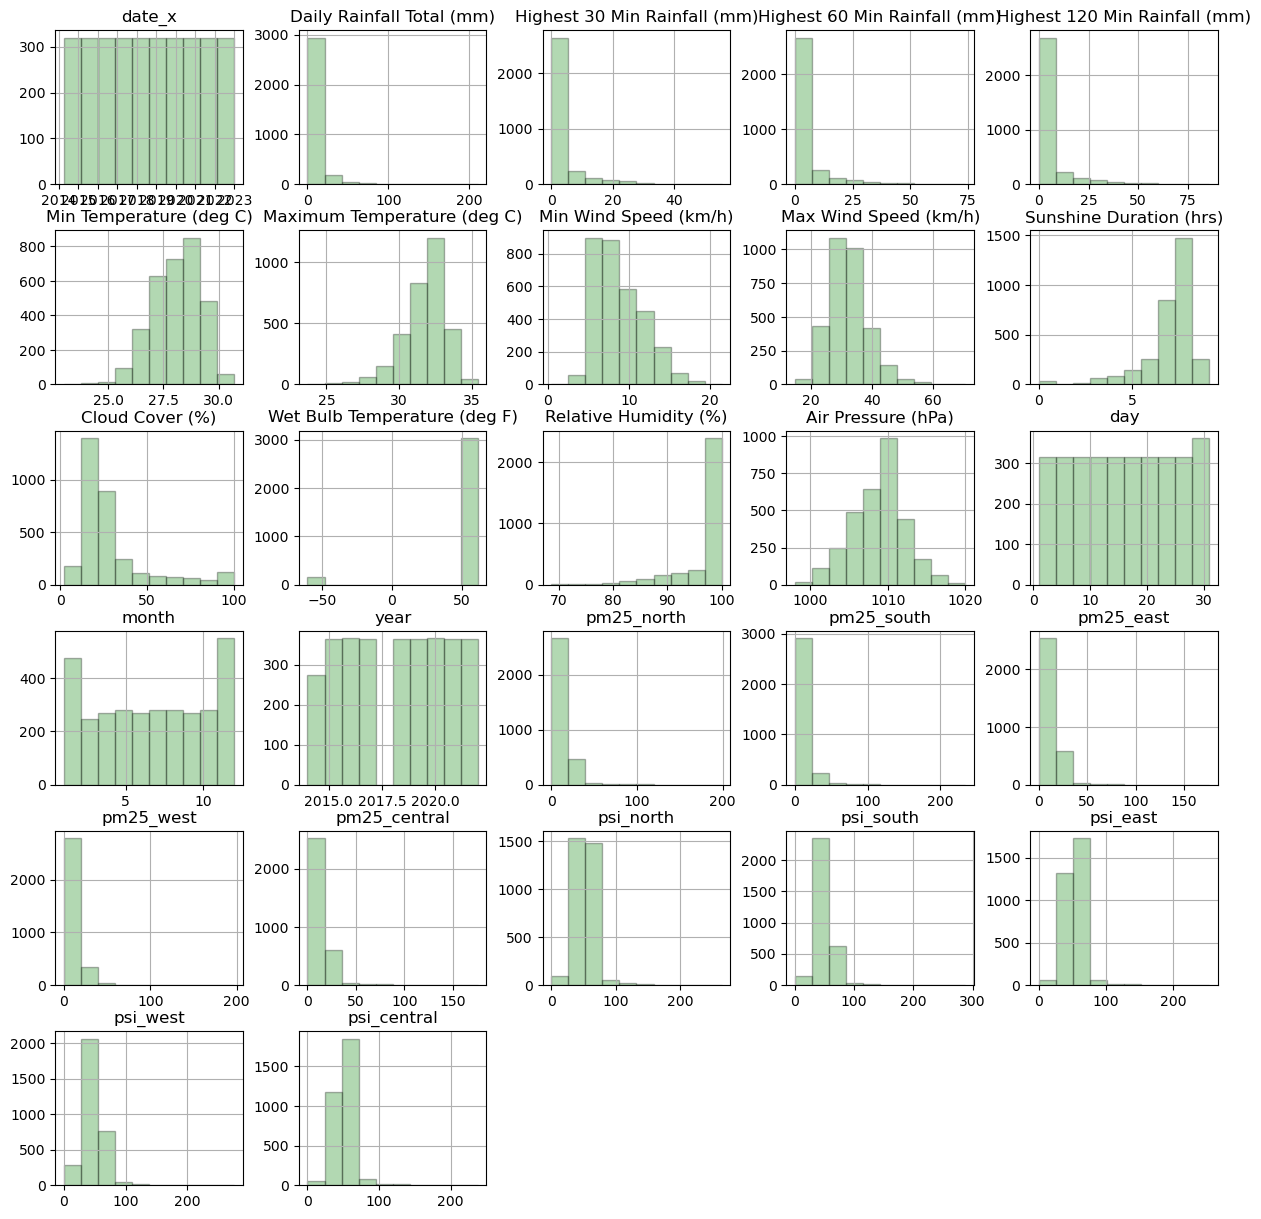

In [49]:
air_weather_df.hist(figsize= (15,15), color ='green',  edgecolor ="black", alpha= 0.3)
plt.show()

#### **5.2 Visualisation of Dataset- Survivability of Patient Groups (Bivariant Analysis)**
***

#### **Correlation Matrix of Dataset**
Explore the potential correlation between the features in the dataset.

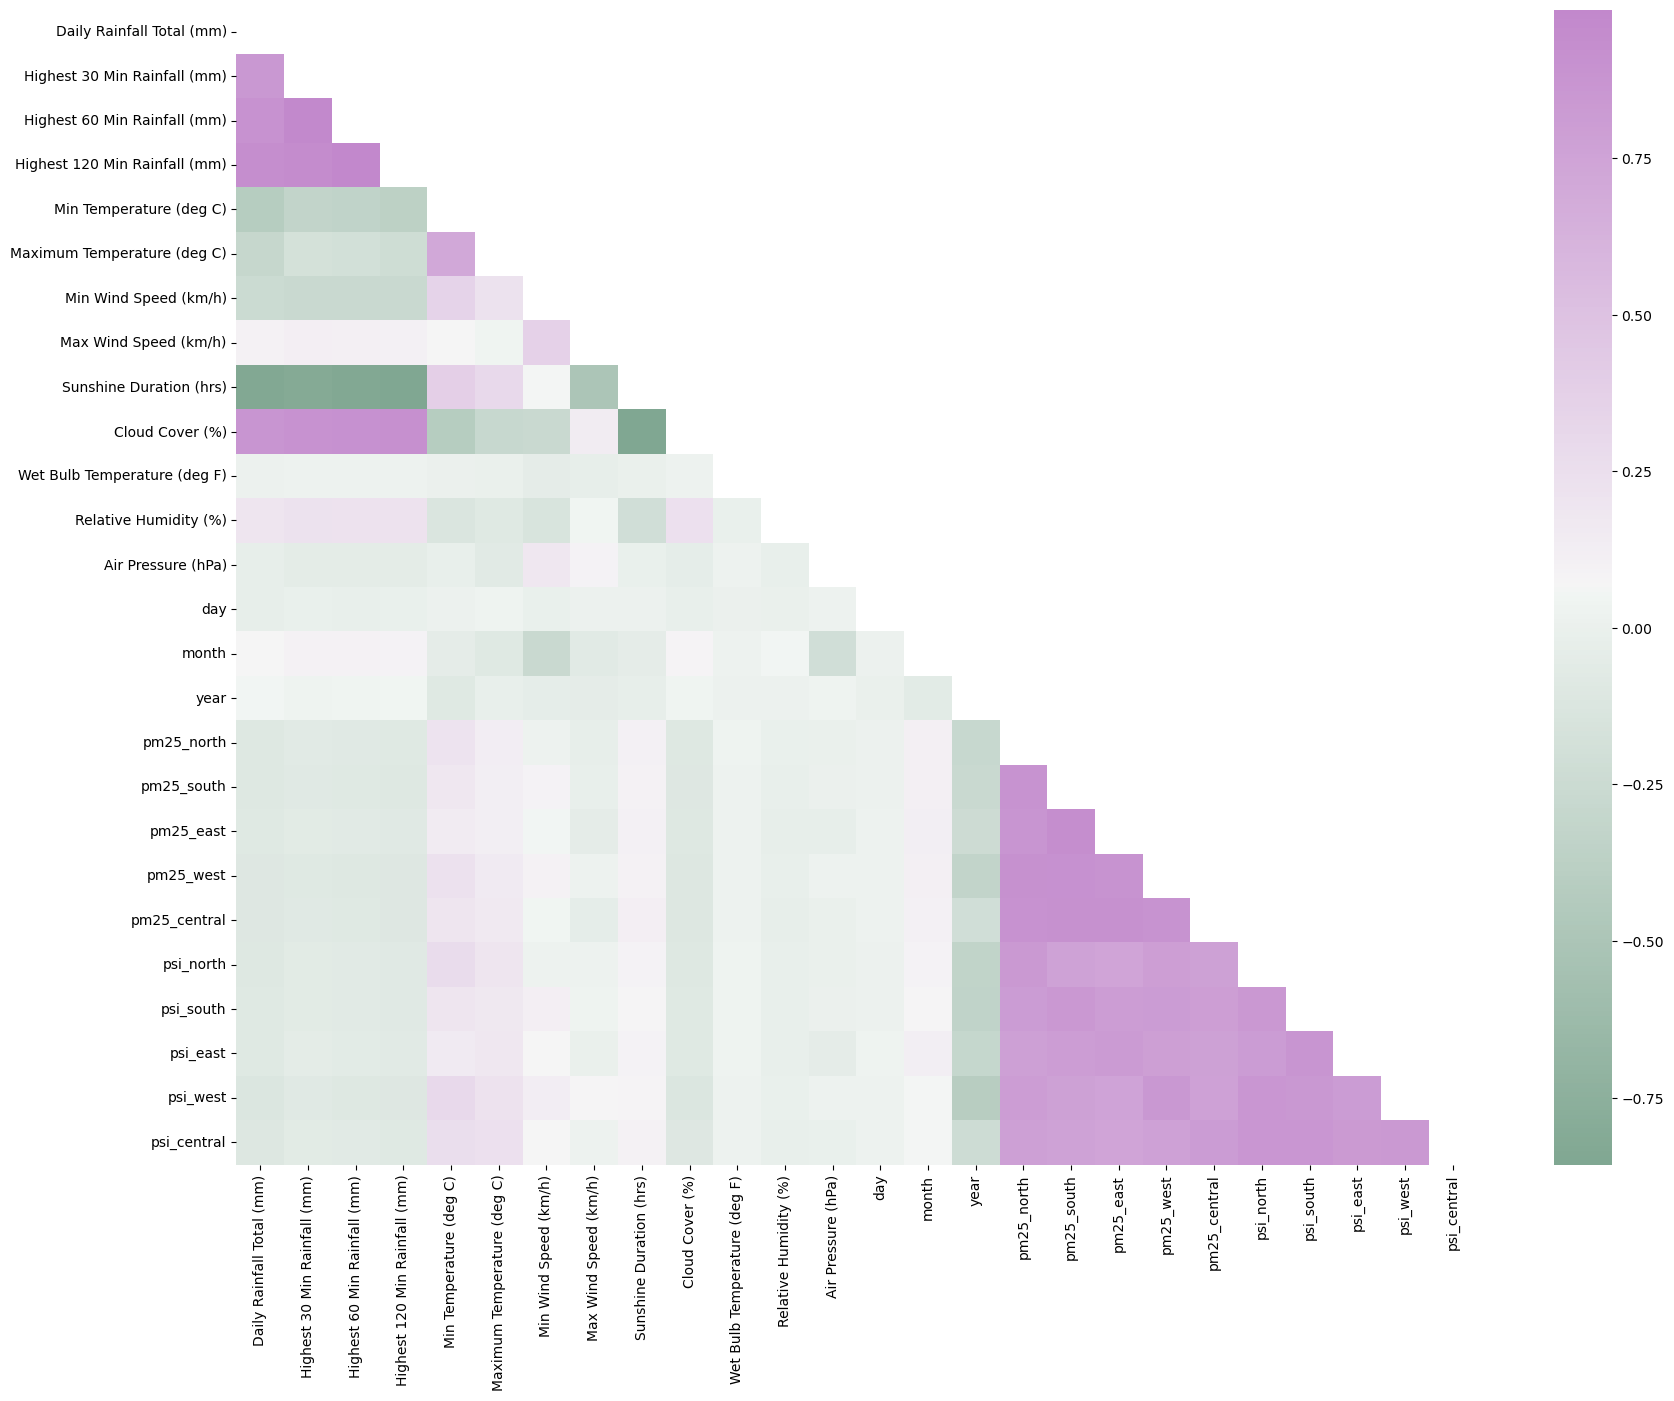

In [51]:
color = sns.diverging_palette(145, 300, s=60, as_cmap=True)

#plot the correlation plot
plt.figure(figsize=(20,15))
corr = air_weather_df.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask= matrix, cmap=color, fmt=".3f", alpha = 0.7)
plt.show()

High correlation of 2 or more independent variables leads to multicollinearity, which makes variables redundant, hard to interpret and creates a problem of overfitting model.

No particular variable pairs has high correlations of >0.7.

In [52]:
# Splitting dataset into survival and non_survivals 
# for better visualisation of the distribution of data
survival_df = encoded_survive_df[encoded_survive_df['Survive'] == 1]
non_survival_df = encoded_survive_df[encoded_survive_df['Survive'] == 0]

NameError: name 'encoded_survive_df' is not defined